<a href="https://colab.research.google.com/github/benayas1/ALV_Framework/blob/master/GNN_Research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
if torch.__version__ == '1.12.1+cu113':
  !pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cu113.html
  !pip install faiss-gpu
else:
  !pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.12.0+cpu.html
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.12.0+cu113.html
     |████████████████████████████████| 1.9 MB 6.6 MB/s 
     |████████████████████████████████| 8.9 MB 23.4 MB/s 
     |████████████████████████████████| 3.5 MB 41.9 MB/s 
     |████████████████████████████████| 2.5 MB 49.8 MB/s 
     |████████████████████████████████| 722 kB 52.7 MB/s 
     |████████████████████████████████| 564 kB 4.8 MB/s 
     |████████████████████████████████| 280 kB 52.8 MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.2.0-py3-none-any.whl size=773302 sha256=b9bb9635cd5b9231aeb709449e9e8e3a0360eaf9a5fb78c25c83ad38e8a197b2
  Stored in directory: /root/.cache/pip/wheels/59/a3/20/198928106d3169865ae73afcbd3d3d1796cf6b429b55c65378
Successfully built torch-geometric
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Succe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 84 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 3.6 MB/s 
     |████████████████████████████████| 1.1 MB 38.4 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=f3e32f464a2fa7d89c253edcad053c1750c58dbe9e88ddde282d757430449da5
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=ade828ad57fdbbdc4c238695e8e6fb908b2bdabade10f038b58a4f84afe49b22
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [4]:
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np
import faiss
from tqdm import tqdm
from torch_geometric.nn import GCNConv, GATv2Conv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.manifold import TSNE
import umap
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

DATA_ROOT = '/content/drive/MyDrive/Estudios/PHD/Label Propagation paper/data/'

# Read Data
In  CSV format

In [7]:
df = pd.read_csv(DATA_ROOT+'cifar10.csv').dropna()
df

,f_00000,f_00001,f_00002,f_00003,f_00004,f_00005,f_00006,f_00007,f_00008,f_00009,...,f_02039,f_02040,f_02041,f_02042,f_02043,f_02044,f_02045,f_02046,f_02047,label
0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,1.723231,0.000000,0.249153,0.0,0.000000,6.0
1,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,3.739717,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,9.0
2,0.0,2.252773,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,9.0
3,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.0
4,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,2.810545,0.0,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16540,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.353456,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,4.840921,0.000000,0.000000,0.000000,0.0,2.552522,5.0
16541,0.0,0.000000,0.0,0.551148,0.0,0.000000,0.000000,0.010473,1.476173,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,6.127621,1.263079,0.0,0.000000,0.0
16542,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,4.0
16543,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.671687,0.0,0.000000,0.000000,0.000000,3.393355,0.0,0.000000,1.0


In [8]:
# Separate embeddings from labels
embeddings = df.iloc[:,:-1].values
labels = df['label'].values
print(f'Embeddings shape {embeddings.shape}, label shape {labels.shape}')

Embeddings shape (16545, 2048), label shape (16545,)


# Preprocess Data

In [9]:
def get_neighbours(embeddings, k=5):
    """"
    Given an embeddings matrix of (n_samples, n_features), gets the k neighbours for each sample
    """
    embeddings = embeddings.copy()
    resource = faiss.StandardGpuResources()
    flat_config = faiss.GpuIndexFlatConfig()
    flat_config.device = int(torch.cuda.device_count()) - 1
    knn = faiss.GpuIndexFlatIP(resource, embeddings.shape[1], flat_config)
    embeddings = np.ascontiguousarray(embeddings).astype(np.float32)
    faiss.normalize_L2(embeddings)
    knn.add(x=embeddings)
    similarity, index_matrix = knn.search(x=embeddings, k=top_k + 1)
    distances = similarity[:,1:]
    index_matrix = index_matrix[:, 1:] 
    return index_matrix, distances

def convert_index_matrix_2_edge_index(index_matrix, similarity):
    """
    Creates a bidirectional edge matrix of (2, n_edges) and a weight matrix of (n_edges, 1)
    """
    edges = []
    weights = []
    for i in range(len(index_matrix)):
        for j in range(len(index_matrix[i])):
            edges.append([i,index_matrix[i][j]])
            weights.append([similarity[i][j]])
            
            # Reversed edge
            edges.append([index_matrix[i][j],i])
            weights.append([similarity[i][j]])

    edges = np.array(edges).T
    weights = np.array(weights)
    return edges, weights

def get_mask(indices, total_length):
    mask = [False] * total_length
    indices.sort()
    for i in indices:
        mask[i] = True
    return mask

def get_train_test_split(labels, train_size=0.05):
    """
    Return train and test masks, which are lists of size labels and are mutually exclusive
    """
    a, b = train_test_split(list(range(len(labels))), train_size=train_size, stratify=labels, random_state=42)
    return get_mask(a, len(labels)), get_mask(b, len(labels))

def get_gnn_data(embeddings, 
                 top_k, 
                 labels,
                 use_global_node=False, 
                 train_size=0.10,
                 print_report=False,
                 return_index_matrix=False):
    """
    Get data in the required format for GNN
    """
    
    index_matrix, similarity = get_neighbours(embeddings, top_k)
    edge_index, weights = convert_index_matrix_2_edge_index(index_matrix, similarity)
    train_mask, test_mask = get_train_test_split(labels, train_size=train_size)

    if use_global_node:
        # A global node is a node connected to all other nodes
        # Its embeddings is the average of the graph
        global_node_embeddings = np.mean(embeddings, axis=0).reshape((-1,embeddings.shape[1]))
        embeddings = np.concatenate([embeddings, global_node_embeddings], axis=0)
        # Add all new edges
        new_edges = []
        for i in range(len(embeddings)-1):
            new_edges.append([i,len(embeddings)-1])
            new_edges.append([len(embeddings)-1,i])
        edge_index = np.concatenate([edge_index, np.array(new_edges).T], axis=1)
        # Edges weight is the average of all weights
        weights = np.concatenate([weights, np.full(((len(embeddings)-1)*2,), fill_value=weights.mean()).reshape(-1,1)])
        # This node goes to the training data
        test_mask.append(True)
        train_mask.append(False)
        # Calculate label of the new node as the mode
        values, freqs = np.unique(labels, return_counts=True)
        global_node_label = values[np.argmax(freqs)]
        labels = np.concatenate([labels, np.array([global_node_label])])

    if print_report:
        print(f'Index Matrix shape {index_matrix.shape}')
        print(f'Edge Index shape {edge_index.shape} ')
        print(f'Weights shape {weights.shape} ')
        print(f'Train mask size {len(train_mask)} Train ratio {sum(train_mask)/len(train_mask)}')
        print(f'Test mask size {len(test_mask)} Test ratio {sum(test_mask)/len(test_mask)}')

    data = Data(x = torch.tensor(embeddings, dtype=torch.float32),
                edge_index = torch.tensor(edge_index, dtype=torch.long),
                edge_attr = torch.tensor(weights, dtype=torch.double),
                y = torch.tensor(labels, dtype=torch.long),
                train_mask = torch.tensor(train_mask, dtype=torch.bool),
                test_mask = torch.tensor(test_mask, dtype=torch.bool)
                )
    
    if return_index_matrix:
        return data, index_matrix
    else:
        return data

def extract_data(data):
    extracted_data = {}
    extracted_data['embeddings'] = data.x.numpy()
    extracted_data['edge_index'] = data.edge_index.numpy()
    extracted_data['weights'] = data.edge_attr.numpy()
    extracted_data['labels'] = data.y.numpy()
    extracted_data['train_mask'] = data.train_mask.numpy()
    extracted_data['test_mask'] = data.test_mask.numpy()
    return extracted_data

top_k = 3
train_size = 0.10
device = 'cuda'
use_global_node = True # Artificial node connecting to every other node to make the graph connected

data, index_matrix = get_gnn_data(embeddings=embeddings,
                                  top_k=top_k,
                                  labels=labels,
                                  train_size=train_size,
                                  use_global_node=False,
                                  print_report=True,
                                  return_index_matrix=True)
data

RuntimeError: ignored

# Health Analysis

100%|██████████| 16545/16545 [01:18<00:00, 212.08it/s]


Initial subgraphs 4524
Merging graphs
Updating node2graph
N disconnected graphs 1
(array([0]), array([16545]))


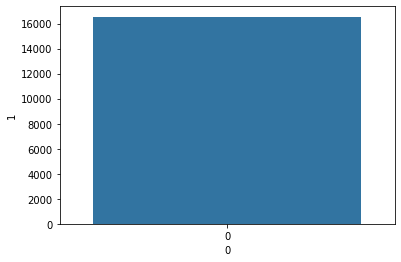

In [7]:
def analyze(index_matrix):
    """
    Counts the number of unconnected graphs generated, excluding the global node
    """
    node2graphid = np.full((len(index_matrix), ), -1)
    graph2node = {}
    
    current_graph_id = 0
    for initial_position in tqdm(range(len(node2graphid))):
    #while np.any(node2graphid==-1):
        #print(f"Graph ID {graph_id}, items remaining {sum(node2graphid==-1)}")
        # Look for the next unassigned node
        if node2graphid[initial_position] != -1:
            continue
        graph2node[current_graph_id] = set()
        # Traverse all the connected nodes
        stack = [initial_position]
        while stack:
            node = stack.pop()
            if node in graph2node[current_graph_id]:
                continue
            graph2node[current_graph_id].add(node)
            node2graphid[node] = current_graph_id
            neighbours = index_matrix[node]
            for neighbour in neighbours:
                stack.append(neighbour)
        current_graph_id += 1
    print(f"Initial subgraphs {current_graph_id}")

    # Merge overlapping graphs
    print('Merging graphs')
    i = 0
    while i < current_graph_id:
        if i not in graph2node:
            i += 1
            continue
        has_changed = False
        current_graph = graph2node[i]
        for j in range(i, current_graph_id):
            if i==j or j not in graph2node:
                continue
            candidate_graph = graph2node[j]
            if len(current_graph.intersection(candidate_graph)) > 0:
                current_graph.update(candidate_graph)
                del graph2node[j]
                has_changed=True
        if not has_changed:
            i += 1
    
    print('Updating node2graph')
    node2graphid = np.full((len(index_matrix), ), -1)
    current_graph_id = 0
    for current_graph_id, (old_id, current_graph) in enumerate(graph2node.items()):
        for item in current_graph:
            if node2graphid[item] != -1:
                print('Error, overlapping not completed properly')
            node2graphid[item] = current_graph_id
        
    return node2graphid

node2graphid = analyze(index_matrix)
print(f"N disconnected graphs {len(np.unique(node2graphid))}")
print(np.unique(node2graphid, return_counts=True))
df_tmp = pd.DataFrame(np.unique(node2graphid, return_counts=True)).T
sns.barplot(data=df_tmp, x=0, y=1)

(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]), array([1652, 1644, 1701, 1669, 1668, 1568, 1690, 1674, 1670, 1609]))


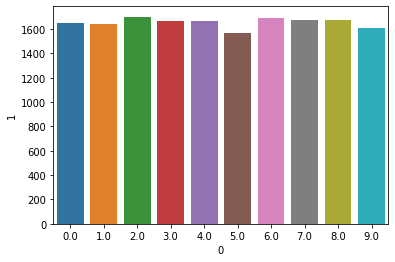

In [6]:
# Check if labels are balanced in the dataset
print(np.unique(labels, return_counts=True))
df_tmp = pd.DataFrame(np.unique(labels, return_counts=True)).T
sns.barplot(data=df_tmp, x=0, y=1)

# GNN

In [34]:
def train(model, data, device):
    model.train()
    model.to(device)
    optimizer.zero_grad()  # Clear gradients.
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    out = model(x, edge_index)  # Perform a single forward pass.
    y = data.y.to(device)
    loss = criterion(out[data.train_mask], y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

def test(model, data):
    model.eval()
    model.to(device)
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    out = model(x, edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    y = data.y.to(device)
    test_correct = pred[data.test_mask] == y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_features, num_classes):
        super().__init__()
        torch.manual_seed(1234567)
        self.first = GATv2Conv(num_features, hidden_channels, heads=1)
        self.second = GATv2Conv(hidden_channels, num_classes)

    def get_embeddings(self, x, edge_index):
        return self.first(x, edge_index)

    def forward(self, x, edge_index):
        x = self.get_embeddings(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)

        x = self.second(x, edge_index)
        return x

## PreVisualize

In [26]:
def visualize(h, color):
    z = umap.UMAP(n_neighbors=15).fit_transform(h.detach().cpu().numpy())
    #z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

In [27]:
model = GCN(hidden_channels=16, num_features=data.x.size()[1], num_classes=len(np.unique(labels)))
print(model)

GCN(
  (layers): ModuleList(
    (0): GATv2Conv(2048, 32, heads=1)
    (1): GATv2Conv(32, 10, heads=1)
  )
)


Calculating visualization...


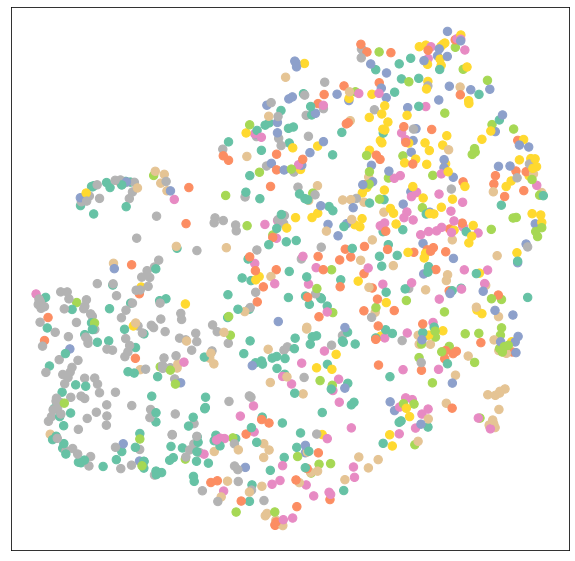

In [28]:
model.eval()
model.to(device)

out = model(data.x.cuda(), data.edge_index.cuda())
print('Calculating visualization...')
visualize(out[:1000], color=data.y[:1000])

## Train GNN

In [29]:
model = GCN(hidden_channels=16, num_features=data.x.size()[1], num_classes=len(np.unique(labels)))
print(model)

GCN(
  (layers): ModuleList(
    (0): GATv2Conv(2048, 32, heads=1)
    (1): GATv2Conv(32, 10, heads=1)
  )
)


In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
torch.cuda.empty_cache()
epochs = 150

print(f'Baseline: {test(model, data)}')

max_acc = -np.inf
best_epochs = -1
for i, epoch in enumerate(range(1, epochs)):
    loss = train(model, data, 'cuda')
    test_acc = test(model, data)
    if test_acc > max_acc:
        best_epochs = i
        max_acc = test_acc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test acc: {test_acc:.4f}')
print(f'Best Epoch: {best_epochs:03d}, Test acc: {max_acc:.4f}')

Baseline: 0.09522530387482372
Epoch: 001, Loss: 3.3119, Test acc: 0.2174
Epoch: 002, Loss: 2.9455, Test acc: 0.3273
Epoch: 003, Loss: 2.0912, Test acc: 0.3490
Epoch: 004, Loss: 1.9301, Test acc: 0.3674
Epoch: 005, Loss: 1.8511, Test acc: 0.3819
Epoch: 006, Loss: 1.8068, Test acc: 0.3974
Epoch: 007, Loss: 1.7462, Test acc: 0.4135
Epoch: 008, Loss: 1.6940, Test acc: 0.4311
Epoch: 009, Loss: 1.6102, Test acc: 0.4500
Epoch: 010, Loss: 1.5458, Test acc: 0.4609
Epoch: 011, Loss: 1.5152, Test acc: 0.4677
Epoch: 012, Loss: 1.4657, Test acc: 0.4710
Epoch: 013, Loss: 1.4223, Test acc: 0.4724
Epoch: 014, Loss: 1.3608, Test acc: 0.4733
Epoch: 015, Loss: 1.3451, Test acc: 0.4755
Epoch: 016, Loss: 1.2843, Test acc: 0.4791
Epoch: 017, Loss: 1.2601, Test acc: 0.4821
Epoch: 018, Loss: 1.2177, Test acc: 0.4858
Epoch: 019, Loss: 1.2043, Test acc: 0.4883
Epoch: 020, Loss: 1.1538, Test acc: 0.4917
Epoch: 021, Loss: 1.1497, Test acc: 0.4912
Epoch: 022, Loss: 1.1253, Test acc: 0.4916
Epoch: 023, Loss: 1.1125

Calculating visualization...


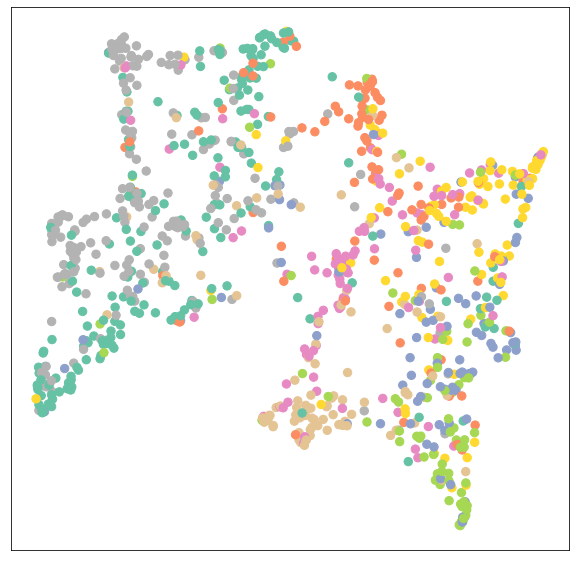

In [18]:
model.eval()
model.to(device)

out = model(data.x.cuda(), data.edge_index.cuda())
print('Calculating visualization...')
visualize(out[:1000], color=data.y[:1000])

## Train GNN with reorg data

In [46]:
model = model = GCN(hidden_channels=16, num_features=data.x.size()[1], num_classes=len(np.unique(labels)))
model

GCN(
  (first): GATv2Conv(2048, 16, heads=1)
  (second): GATv2Conv(16, 10, heads=1)
)

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
torch.cuda.empty_cache()
epochs = 150

print(f'Baseline: {test(model, data)}')

max_acc = -np.inf
best_epochs = -1
for i, epoch in enumerate(range(1, epochs)):
    loss = train(model, data, 'cuda')
    test_acc = test(model, data)
    if test_acc > max_acc:
        best_epochs = i
        max_acc = test_acc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test acc: {test_acc:.4f}')

    # Recalculate graph
    x = data.x.to(device)
    edge_index = data.edge_index.to(device)
    new_embeddings = model.get_embeddings(x, edge_index).cpu().detach().numpy()

    data = get_gnn_data(new_embeddings,
                        top_k=top_k,
                        labels=labels,)

print(f'Best Epoch: {best_epochs:03d}, Test acc: {max_acc:.4f}')

Baseline: 0.10053052179168626
Epoch: 001, Loss: 2.4944, Test acc: 0.2397
Epoch: 002, Loss: 2.1336, Test acc: 0.3105
Epoch: 003, Loss: 1.9868, Test acc: 0.3597
Epoch: 004, Loss: 1.8962, Test acc: 0.3977
Epoch: 005, Loss: 1.8241, Test acc: 0.4192
Epoch: 006, Loss: 1.7550, Test acc: 0.4268
Epoch: 007, Loss: 1.6785, Test acc: 0.4372
Epoch: 008, Loss: 1.6416, Test acc: 0.4435
Epoch: 009, Loss: 1.5559, Test acc: 0.4483
Epoch: 010, Loss: 1.5245, Test acc: 0.4559
Epoch: 011, Loss: 1.4943, Test acc: 0.4622
Epoch: 012, Loss: 1.4256, Test acc: 0.4659
Epoch: 013, Loss: 1.3950, Test acc: 0.4681
Epoch: 014, Loss: 1.3342, Test acc: 0.4721
Epoch: 015, Loss: 1.2830, Test acc: 0.4777
Epoch: 016, Loss: 1.2480, Test acc: 0.4826
Epoch: 017, Loss: 1.2264, Test acc: 0.4869
Epoch: 018, Loss: 1.2042, Test acc: 0.4927
Epoch: 019, Loss: 1.1535, Test acc: 0.4933
Epoch: 020, Loss: 1.1373, Test acc: 0.4939
Epoch: 021, Loss: 1.0722, Test acc: 0.4972
Epoch: 022, Loss: 1.0795, Test acc: 0.4989
Epoch: 023, Loss: 1.0328

# Label Propagation Algorithm

In [19]:
from sklearn.semi_supervised import LabelPropagation

In [20]:
# Splitting train test
a, b = train_test_split(list(range(len(labels))), train_size=train_size, stratify=labels, random_state=42)
labels_lp = np.copy(labels)
labels_lp[b] = -1

In [21]:
# Label Propagation
lp = LabelPropagation('knn', n_neighbors=top_k, n_jobs=-1)
lp.fit(embeddings, labels_lp)

LabelPropagation(kernel='knn', n_jobs=-1, n_neighbors=3)

In [22]:
# Accuracy Score
test_correct = lp.transduction_[b] == labels[b]
test_acc = int(test_correct.sum()) / len(b)  # Derive ratio of correct predictions.
print(f"Accuracy using LP {test_acc}")

Accuracy using LP 0.28990665502652607
